In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

# Importing Data

In [2]:
df = pd.read_csv('zillow_data.csv')
df.rename(columns={'RegionName':'zipcode'}, inplace=True)
df.head()

,RegionID,zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


Calculate growth over the last 9 years from (2009 to 2018)

In [3]:
df['growth'] = (df['2018-04']-df['2009-04'])/df['2009-04']

In [4]:
df['growth']

0        0.282479
1        0.603388
2        0.341602
3        0.259274
4        0.009975
           ...   
14718    0.109168
14719    0.123942
14720    0.232902
14721    0.027211
14722    0.402985
Name: growth, Length: 14723, dtype: float64

### Focusing on homes in Arizona

In [5]:
df = df[df['State']=='AZ']

In [6]:
df = df[(df['Metro'] == 'Phoenix')]

df = df[(df['zipcode'] == 85253)|(df['zipcode'] == 85262)|
(df['zipcode'] == 85377)| (df['zipcode'] == 85255)|(df['zipcode'] == 85266)|
                             (df['zipcode'] == 85259)|(df['zipcode'] == 85258)|
                             (df['zipcode'] == 85018)|(df['zipcode'] == 85263)|
                             (df['zipcode'] == 85054)]

Number of Unique Zipcodes in Arizona: 230

In [7]:
df['zipcode'].value_counts().sum()

10

# Reshaping Data

In [8]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['zipcode', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName','growth'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [9]:
melted = melt_data(df)
melted = melted.set_index('time')
melted.shape

(2650, 9)

In [10]:
melted = melted['2009-04-01':'2018-04-01']

### Grouping By zipcode

In [11]:
grouped = melted.groupby(['zipcode','time','growth']).aggregate({'value':'mean'})
grouped

value
zipcode time       growth            
85018   2009-04-01 0.634557  397600.0
        2009-05-01 0.634557  392500.0
        2009-06-01 0.634557  386800.0
        2009-07-01 0.634557  381300.0
        2009-08-01 0.634557  376200.0
...                               ...
85377   2017-12-01 0.253335  865500.0
        2018-01-01 0.253335  864700.0
        2018-02-01 0.253335  863200.0
        2018-03-01 0.253335  859600.0
        2018-04-01 0.253335  854900.0

[1090 rows x 1 columns]

### Resampling to Monthly

In [12]:
resampled = melted.groupby('zipcode').resample('MS').mean().drop('zipcode',axis=1)
resampled

RegionID  SizeRank    growth     value
zipcode time                                              
85018   2009-04-01     94734      1075  0.634557  397600.0
        2009-05-01     94734      1075  0.634557  392500.0
        2009-06-01     94734      1075  0.634557  386800.0
        2009-07-01     94734      1075  0.634557  381300.0
        2009-08-01     94734      1075  0.634557  376200.0
...                      ...       ...       ...       ...
85377   2017-12-01     94951     11251  0.253335  865500.0
        2018-01-01     94951     11251  0.253335  864700.0
        2018-02-01     94951     11251  0.253335  863200.0
        2018-03-01     94951     11251  0.253335  859600.0
        2018-04-01     94951     11251  0.253335  854900.0

[1090 rows x 4 columns]

In [14]:
# # melted df
# melted = melt_data(df)
# melted = melted.set_index('time')
# melted = melted['2009-04-01':'2018-04-01']

# #groupby zipcode
# grouped = melted.groupby(['zipcode','time','growth']).aggregate({'value':'mean'})

# # resampled df to monthly freq
# resampled = melted.groupby('zipcode').resample('MS').mean().drop('zipcode',axis=1)

### Adding ZHVI forecasted monthly growth column

In [15]:
# melted df
melted = melt_data(df)
melted = melted.set_index('time')
melted = melted['2009-04-01':'2018-04-01']

#groupby zipcode
grouped = melted.groupby(['zipcode','time','growth']).aggregate({'value':'mean'})

# resampled df
resampled = melted.groupby('zipcode').resample('MS').mean().drop('zipcode',axis=1)

###############
# Growth Calculation
###############

# shift by one period (month)
resampled_shift_1 = resampled[['value']].shift(1)
resampled_shift_1.bfill(inplace=True)

# reset the indexes to perform calculation of growth
resampled = resampled.reset_index()
resampled_shift_1 = resampled_shift_1.reset_index()

# Growth Calculation
resampled['growth'] = (resampled['value'] - resampled_shift_1['value'])/(resampled_shift_1['value'])

# set the index back to zipcode and time multi-index
resampled.set_index(['zipcode','time'],inplace=True)

In [16]:
resampled =  resampled[['growth','value']]
resampled

growth     value
zipcode time                          
85018   2009-04-01  0.000000  397600.0
        2009-05-01 -0.012827  392500.0
        2009-06-01 -0.014522  386800.0
        2009-07-01 -0.014219  381300.0
        2009-08-01 -0.013375  376200.0
...                      ...       ...
85377   2017-12-01  0.000231  865500.0
        2018-01-01 -0.000924  864700.0
        2018-02-01 -0.001735  863200.0
        2018-03-01 -0.004171  859600.0
        2018-04-01 -0.005468  854900.0

[1090 rows x 2 columns]

# EDA

### Plotting zipcode series

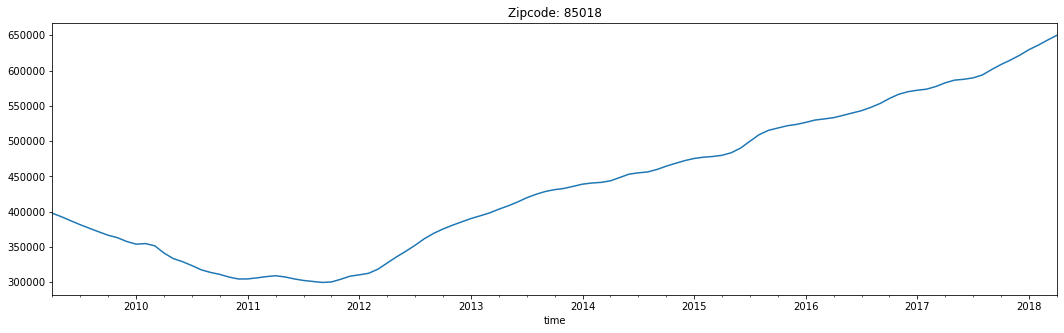

In [38]:
def plot_zip(zipcode,column):
    series = resampled.loc[zipcode,column]
    fig, ax = plt.subplots(figsize=(18,5))
    series.plot(ax=ax)
    ax.set_title("Zipcode: "+ str(zipcode));
    
plot_zip(85018,'value')

In [39]:
def stationarity_check(TS):
    dftest = adfuller(TS)
    
    
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

In [40]:
stationarity_check(resampled.loc[85018,'value'])

Results of Dickey-Fuller Test: 

Test Statistic                   0.512578
p-value                          0.985250
#Lags Used                       4.000000
Number of Observations Used    104.000000
Critical Value (1%)             -3.494850
Critical Value (5%)             -2.889758
Critical Value (10%)            -2.581822
dtype: float64


### Looking at Value stationarity

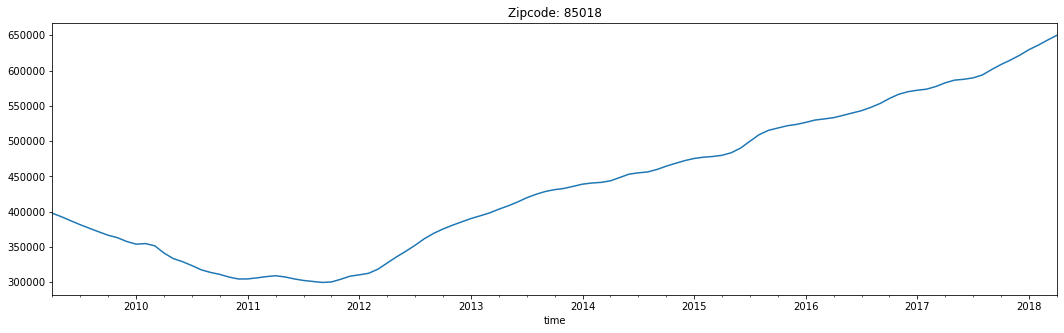

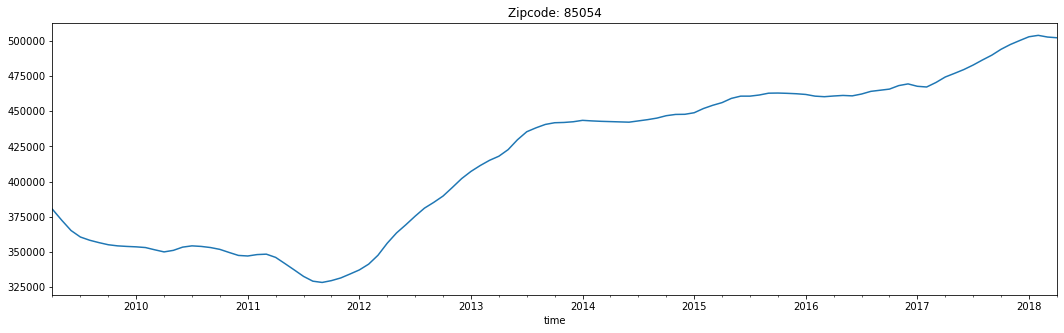

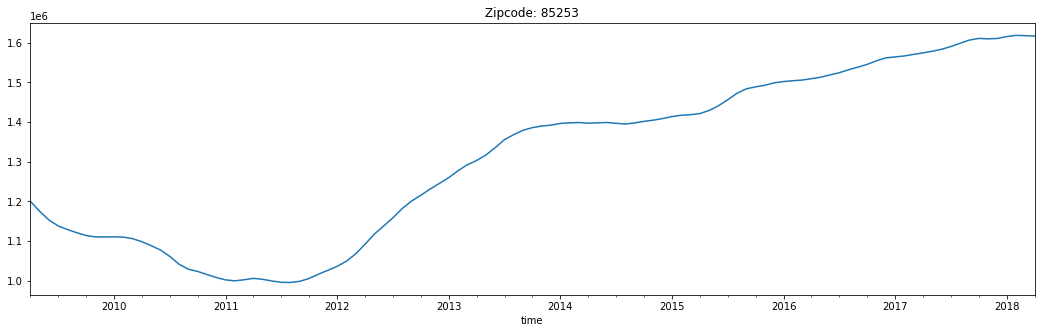

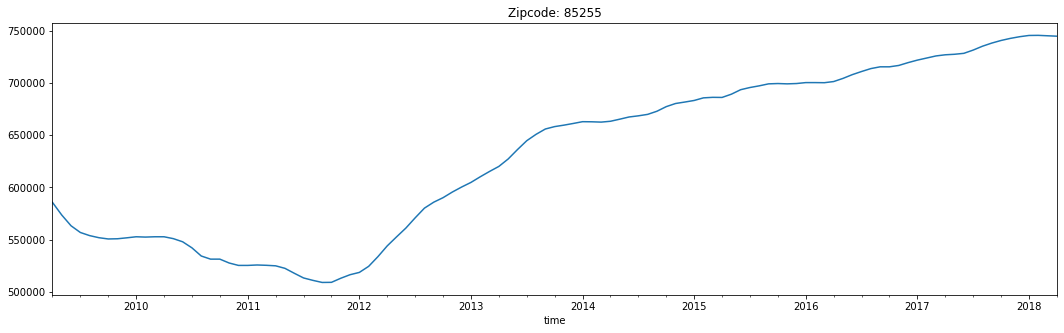

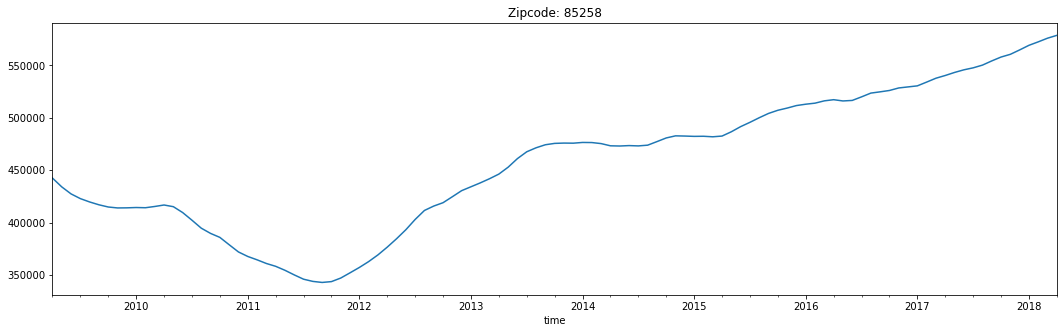

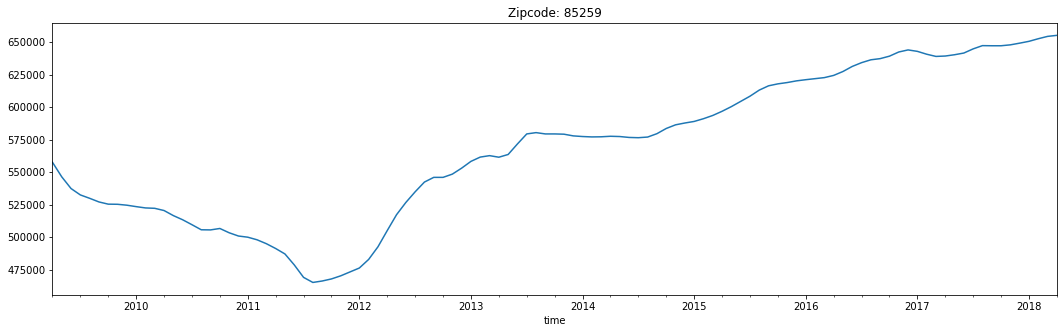

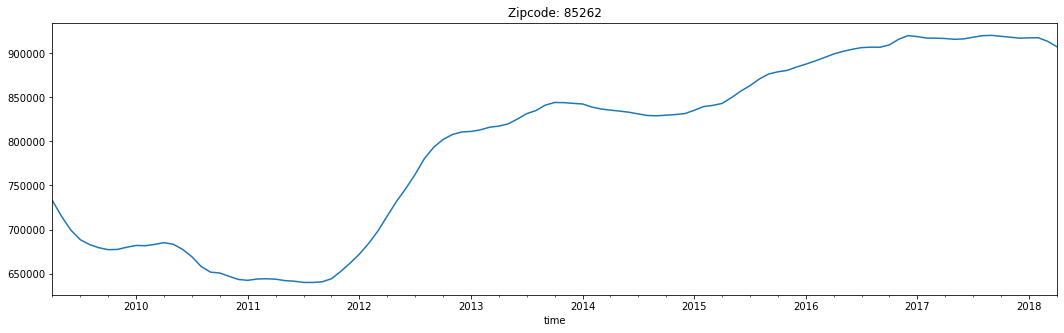

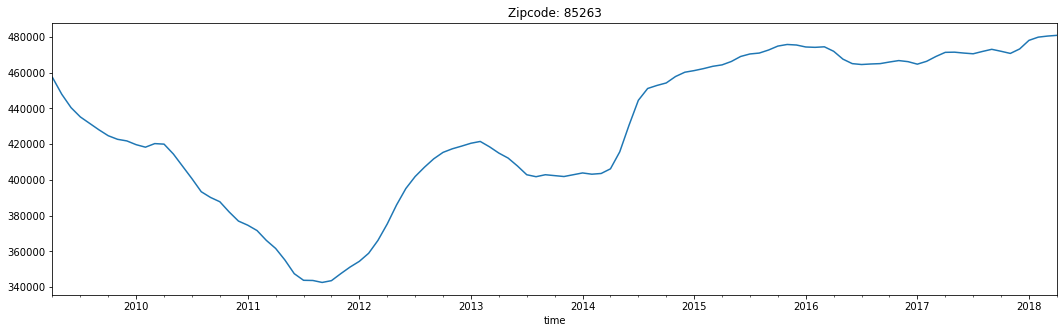

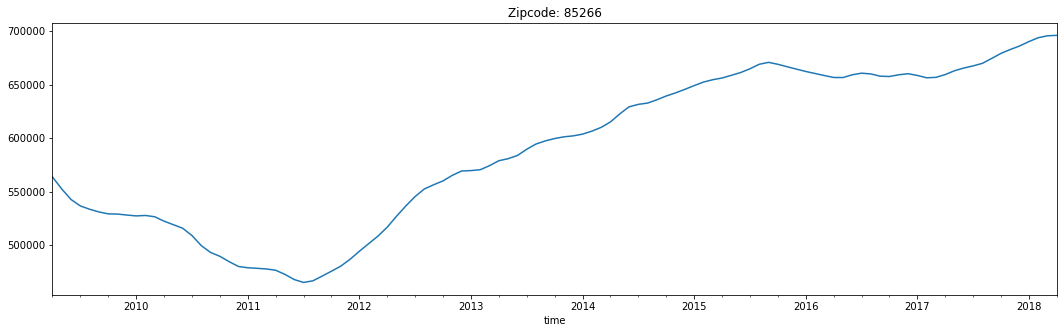

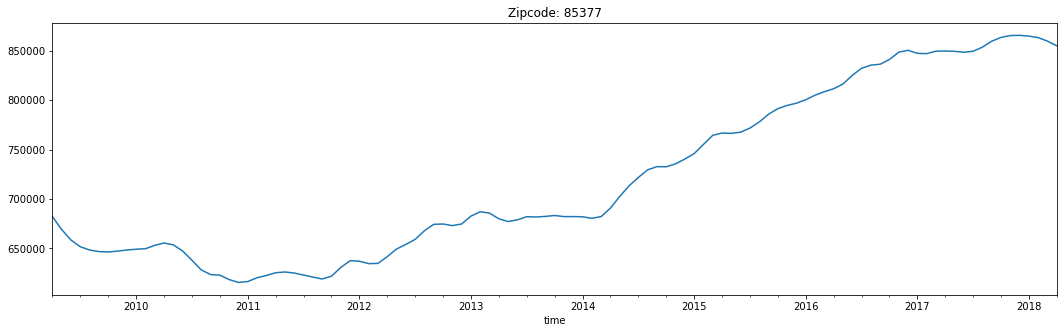

In [41]:
copy = resampled.reset_index()
for z in copy.zipcode.unique():
    plot_zip(z,'value')

In [37]:
for z in copy.zipcode.unique():
    print("zipcode: "+ str(z))
    stationarity_check(resampled.loc[z,'value'])

zipcode: 85018
Results of Dickey-Fuller Test: 

Test Statistic                   0.512578
p-value                          0.985250
#Lags Used                       4.000000
Number of Observations Used    104.000000
Critical Value (1%)             -3.494850
Critical Value (5%)             -2.889758
Critical Value (10%)            -2.581822
dtype: float64
zipcode: 85054
Results of Dickey-Fuller Test: 

Test Statistic                 -0.960562
p-value                         0.767376
#Lags Used                     12.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64
zipcode: 85253
Results of Dickey-Fuller Test: 

Test Statistic                  -1.355085
p-value                          0.603610
#Lags Used                       8.000000
Number of Observations Used    100.000000
Critical Value (1%)             -3.497501
Critical Value (5%)             -2.

NOT Stationary

### Looking at Growth Stationary

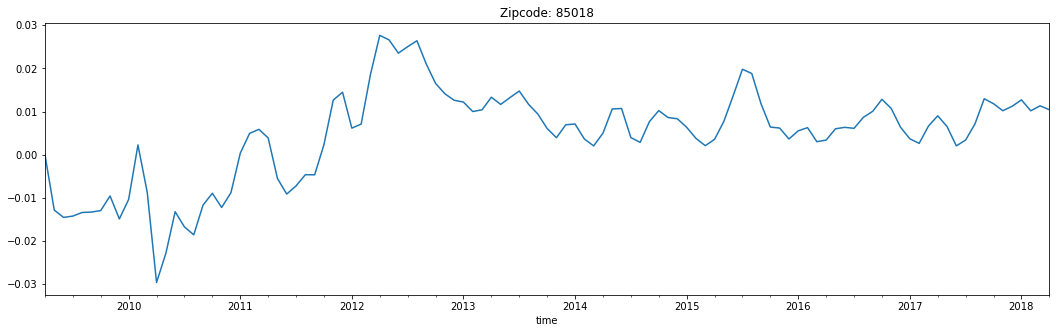

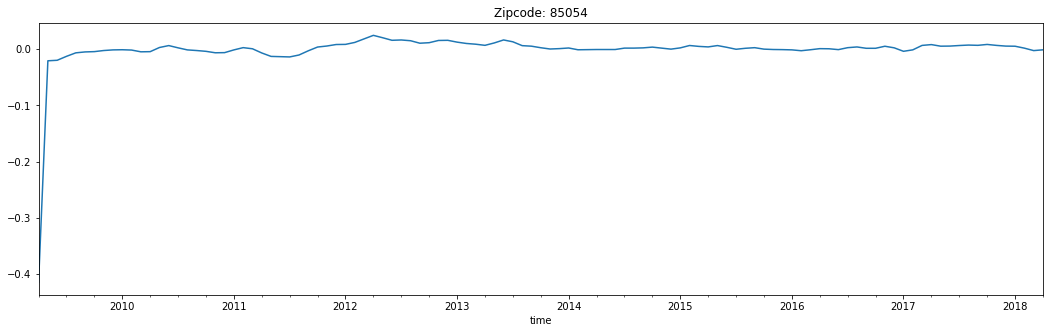

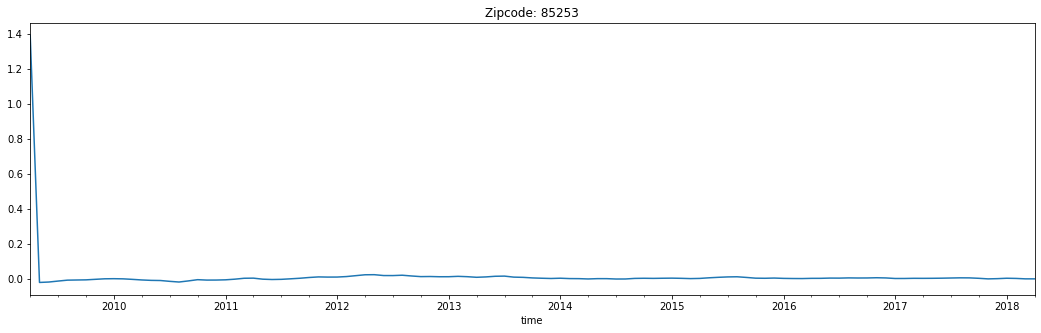

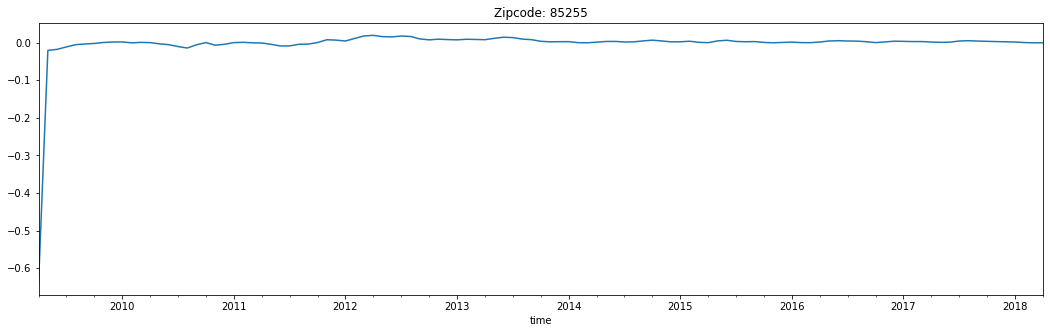

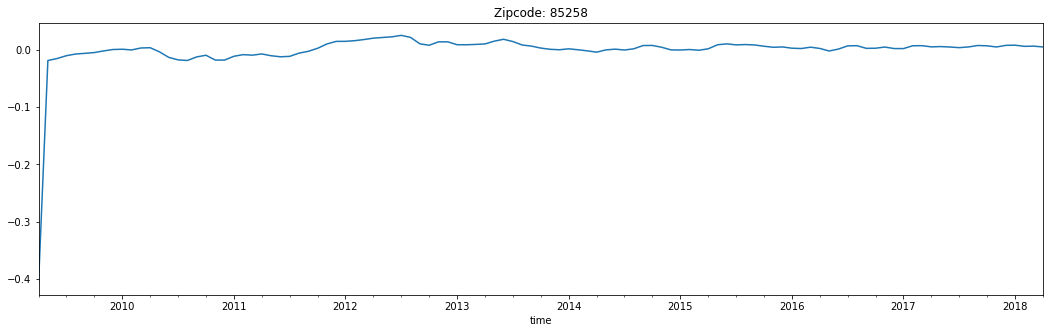

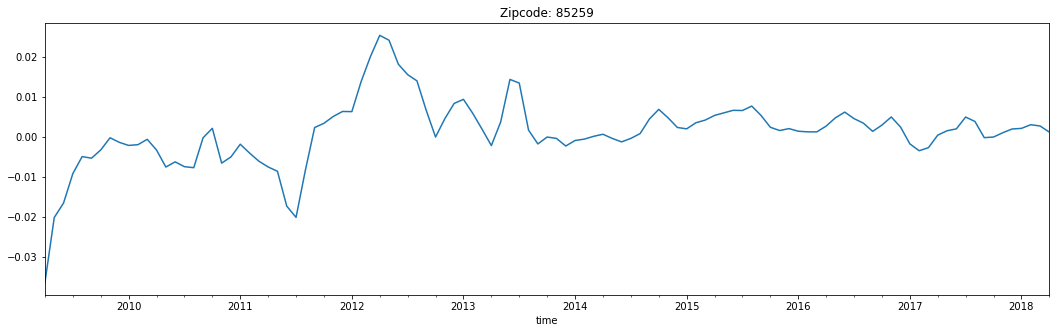

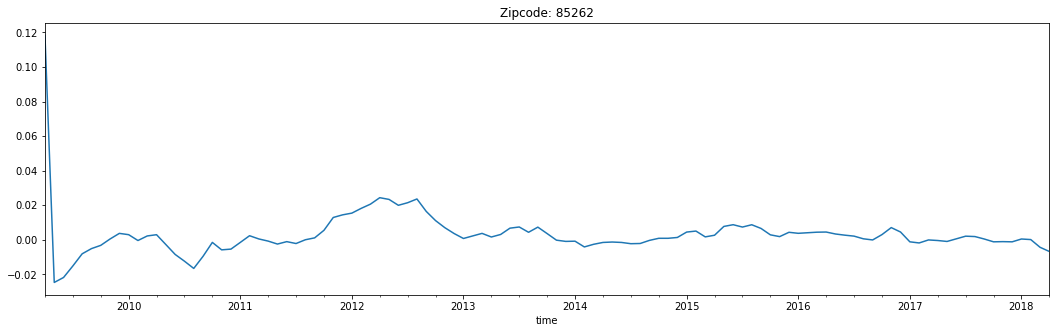

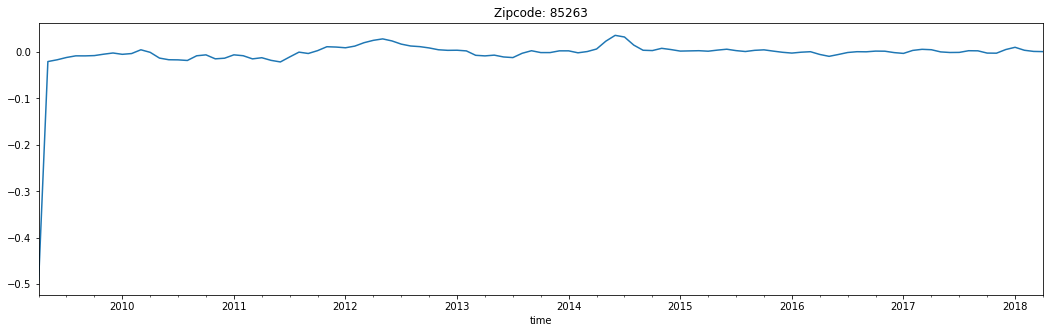

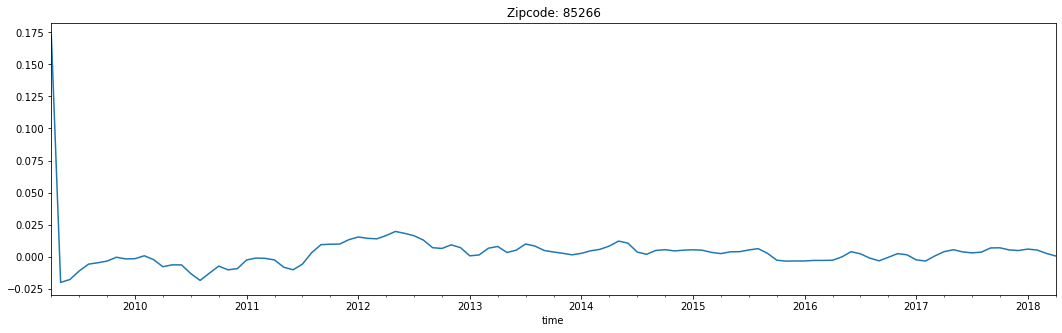

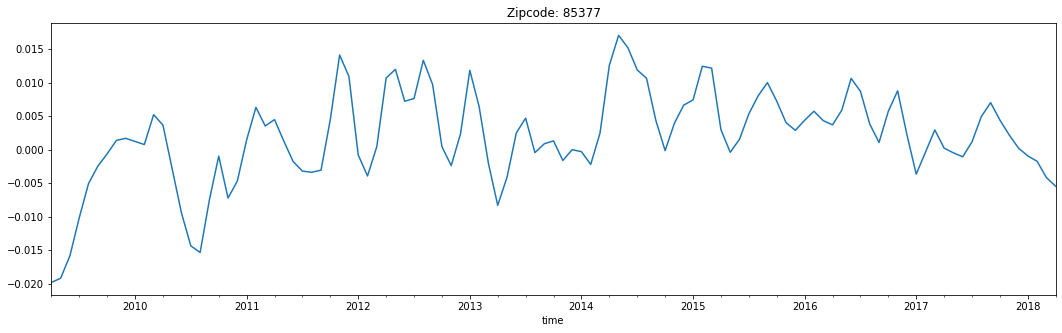

In [44]:
for z in copy.zipcode.unique():
    plot_zip(z,'growth')

In [45]:
for z in copy.zipcode.unique():
    print("zipcode: "+ str(z))
    stationarity_check(resampled.loc[z,'growth'])

zipcode: 85018
Results of Dickey-Fuller Test: 

Test Statistic                 -2.846077
p-value                         0.051987
#Lags Used                     13.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64
zipcode: 85054
Results of Dickey-Fuller Test: 

Test Statistic                 -2.763005
p-value                         0.063756
#Lags Used                     11.000000
Number of Observations Used    97.000000
Critical Value (1%)            -3.499637
Critical Value (5%)            -2.891831
Critical Value (10%)           -2.582928
dtype: float64
zipcode: 85253
Results of Dickey-Fuller Test: 

Test Statistic                  -2.106619
p-value                          0.241861
#Lags Used                       7.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611


Not Stationary Either

### Trying out Facebook Prophet Forecasting on Zipcode: 85018

In [17]:
import warnings
warnings.simplefilter('ignore')

from fbprophet import Prophet

In [18]:
model = Prophet(interval_width=0.95,weekly_seasonality=True, daily_seasonality=True)

In [19]:
zipcode_85018 = resampled.loc[85018]
zipcode_85018.rename(columns={'value':'y'},inplace=True)
zipcode_85018.index.name = 'ds'
zipcode_85018 = zipcode_85018.reset_index()
zipcode_85018 = zipcode_85018[['ds','y']]
zipcode_85018

,ds,y
0,2009-04-01,397600.0
1,2009-05-01,392500.0
2,2009-06-01,386800.0
3,2009-07-01,381300.0
4,2009-08-01,376200.0
...,...,...
104,2017-12-01,621700.0
105,2018-01-01,629600.0
106,2018-02-01,636000.0
107,2018-03-01,643200.0


In [20]:
model.fit(zipcode_85018)

Trying to forecast home value for the next 60 months (or 5 years)

In [21]:
future = model.make_future_dataframe(periods=5*12,freq='M')

In [22]:
forecast = model.predict(future)

In [23]:
forecast[['ds','yhat']].tail()

,ds,yhat
164,2022-11-30,885914.978074
165,2022-12-31,891311.550735
166,2023-01-31,894086.236153
167,2023-02-28,905123.926820
168,2023-03-31,906964.882340
